# Table of Contents
1. [Import Libraries](#1)
2. [Data preparation for tensorflow](#2)
3. [Tensorflow Implementation](#3)
4. [Data preparation for pytorch](#4)
5. [Pytorch Implementation](#5)

<a id="1"><a>
## Libraries
    

In [ ]:
!pip install segmentation_models_pytorch

In [1]:
import nibabel as nib
import time
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.feature_extraction import create_feature_extractor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

import segmentation_models_pytorch as smp

In [2]:
torchvision.__version__

'0.15.2+cpu'

In [ ]:
pip install segmentation-models-pytorch

### Try with one image first

(240, 240, 155)


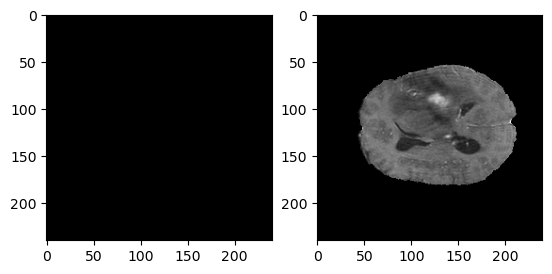

In [3]:
img = nib.load('D:/archive (4)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii')
img_array = img.get_fdata()
print(img_array.shape)
plt.subplot(121)
plt.imshow(img_array[:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(img_array[:,:,80], cmap='gray')

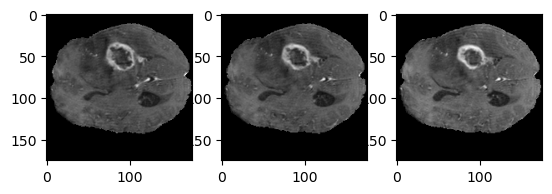

In [4]:
i = 72
plt.subplot(131)
plt.imshow(img_array[40:215, 40:215, i], cmap='gray')
plt.subplot(132)
plt.imshow(img_array[40:215, 40:215, i+1], cmap='gray')
plt.subplot(133)
plt.imshow(img_array[40:215, 40:215, i+2], cmap='gray')

NameError: name 'mask_array' is not defined

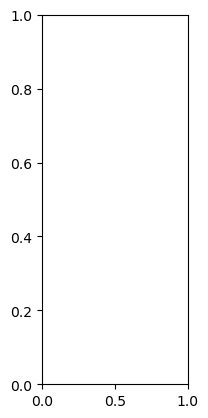

In [5]:
i = 72
plt.subplot(131)
plt.imshow(mask_array[40:215, 40:215, i], cmap='gray')
plt.subplot(132)
plt.imshow(mask_array[40:215, 40:215, i+1], cmap='gray')
plt.subplot(133)
plt.imshow(mask_array[40:215, 40:215, i+2], cmap='gray')

In [5]:
x = img_array/np.max(img_array)
print(x.max())
print(type(x[0,0,0]))
x = x.astype(np.float32)
print(type(x[0,0,0]))

1.0
<class 'numpy.float64'>
<class 'numpy.float32'>


(240, 240, 155)
[0 1 2 4]


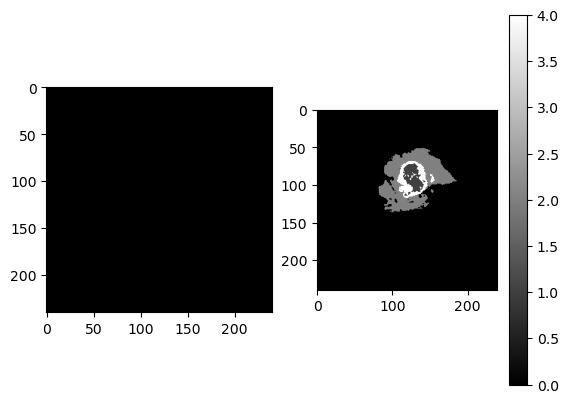

In [7]:
mask = nib.load('D:/archive (4)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii')
mask_array = mask.get_fdata().astype(np.uint8)
print(mask_array.shape)
print(np.unique(mask_array))
plt.subplot(121)
plt.imshow(mask_array[:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(mask_array[:,:,67], cmap='gray')
plt.colorbar()

In [8]:
print(np.unique(mask_array[:,:,0]))
print(np.unique(mask_array[:,:,67]))

[0]
[0 1 2 4]


In [9]:
mask_array[mask_array == 4] = 3
np.unique(mask_array)

array([0, 1, 2, 3], dtype=uint8)

In [10]:
black = []
good = []
for i in range(155):
    if np.unique(mask_array[:,:,i] == 0)[0] == True:
        black.append(i)
    else:
        good.append(i)
print(black)
print(good)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]


In [11]:
size = img_array[40:220, 40:220, 30:113].shape
size

(180, 180, 83)

In [12]:
mask_array[:,:,0].shape

(240, 240)

In [13]:
mask_array =  to_categorical(mask_array[:,:,0], num_classes=4)
mask_array = mask_array.astype(np.uint8)
mask_array.shape

(240, 240, 4)

In [ ]:
mask_array[0,0]

In [14]:
train_images_paths = sorted(glob.glob('D:/archive (4)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
train_masks_paths = sorted(glob.glob('D:/archive (4)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))
train_masks_paths.insert(354,'D:/archive (4)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii')
scaler = MinMaxScaler()
print(len(train_images_paths))
print(len(train_masks_paths))

369
369


In [15]:
x_train, x_test, y_train, y_test = train_test_split(train_images_paths, train_masks_paths, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print(len(x_train))
print(len(x_val))
print(len(x_test))

298
34
37


<a id="2"><a>
## Data preparation for tensorflow

In [16]:
def load_img(img_list):
    train_images= []
    for i, image_path in enumerate(img_list):    
#         print(i)
        image_t1ce= nib.load(image_path).get_fdata()
        image_t1ce = image_t1ce/np.max(image_t1ce)
#         image_t1ce= scaler.fit_transform(image_t1ce.reshape(-1, image_t1ce.shape[-1])).reshape(image_t1ce.shape)
        image_t1ce = image_t1ce.astype(np.float32)
#         temp_combined_images = temp_image_t1ce[...,np.newaxis]
#         print(temp_combined_images.shape)
#         image_t1ce= image_t1ce[40:220, 40:220, 30:113]
        image_t1ce= image_t1ce[:, :, 30:113]
        for j in range(83):
            channel = image_t1ce[:,:,j]
            RGB_img = np.repeat(channel[...,np.newaxis], 3, axis=-1)
#             print("RGB: ", RGB_img.shape)
            train_images.append(RGB_img)
    
    train_images = np.array(train_images)
    return train_images

def load_mask( mask_list):
    train_masks = []
    for i, mask_path in enumerate(mask_list): 
        
        mask = nib.load(mask_path).get_fdata()
        mask[mask==4] = 3  #Reassign mask values 4 to 3
#         mask = mask[40:220, 40:220, 30:113]
        mask = mask[:, :, 30:113]
#         temp_mask= to_categorical(temp_mask, num_classes=4)
        for j in range(83):
            channel = mask[:,:,j]
            channel =  to_categorical(channel, num_classes=4)
            channel = channel.astype(np.float32)
            train_masks.append(channel)
#             train_masks.append(channel[...,np.newaxis])
    
    train_masks = np.array(train_masks)
    return train_masks



def imageLoader( img_list,  mask_list,batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_list[batch_start:limit])
#             X_new=np.moveaxis(X,-1,1)
#             X_new= X
            Y = load_mask( mask_list[batch_start:limit])
#             Y_new=np.moveaxis(Y,-1,1)

            yield (X,Y)#a tuple with two numpy arrays with batch_size samples    
#             yield (X_new,[ Y_new , X_new] )#a tuple with two numpy arrays with batch_size samples     


            batch_start += batch_size   
            batch_end += batch_size

############################################

In [17]:
cc = load_mask(train_masks_paths[:10])
cc.shape

(830, 240, 240, 4)

In [18]:
np.unique(cc[0])

array([0., 1.], dtype=float32)

<a id="3"><a>
# Tensorflow

In [19]:
batch_size = 1
IMAGE_SIZE = 240
NUM_CLASSES = 4

In [20]:
train_datagen = imageLoader(x_train, y_train, batch_size)
# val_datagen = imageLoader(x_test, y_test, batch_size)

In [21]:
def convolution_block(block_input,num_filters=128, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)
    print("Inside dspp, out_pool: ", out_pool.shape)
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [22]:
resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_shape = (240,240,3))
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 246, 246, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 120, 120, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 120, 120, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 60, 60, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 60, 60, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 60, 60, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 30, 30, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 30, 30, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 30, 30, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 15, 15, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 15, 15, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 15, 15, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 15, 15, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 15, 15, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 15, 15, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 15, 15, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 15, 15, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 15, 15, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 15, 15, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [23]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    resnet50.trainable = False
    x = resnet50.get_layer("conv4_block6_2_relu").output
    print("dspp in: ", x.shape)
    x = DilatedSpatialPyramidPooling(x)
    
    print("dspp out: ", x.shape)
    print(image_size // 4 // x.shape[1])
    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=24, kernel_size=1)
    
    print("encoder out: ", input_a.shape)
    print("first out: ", input_b.shape)
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), activation='softmax',padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [24]:
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
# model.summary()

dspp in:  (None, 15, 15, 256)
Inside dspp, out_pool:  (None, 15, 15, 128)
dspp out:  (None, 15, 15, 128)
4
encoder out:  (None, 60, 60, 128)
first out:  (None, 60, 60, 24)


In [26]:
checkpoint_filepath = 'D:/archive (4)/'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    save_best_only = True
    )

In [27]:
epsilon = 1e-7
def dice_coeff(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + epsilon) / ( K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)
    return dice

In [28]:
def dice_loss(y_true, y_pred):
    dice = dice_coeff(y_true, y_pred)
    return 1 - dice

In [29]:
# loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=dice_loss,
    metrics=dice_coeff,
)

In [30]:
history = model.fit(train_datagen, epochs=25, steps_per_epoch=10, callbacks=[checkpoint])

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.3788 - dice_coeff: 0.6212 INFO:tensorflow:Assets written to: D:/archive (4)\assets


INFO:tensorflow:Assets written to: D:/archive (4)\assets


10/10 [==============================] - 159s 16s/step - loss: 0.3788 - dice_coeff: 0.6212
Epoch 2/25
10/10 [==============================] - ETA: 0s - loss: 0.1628 - dice_coeff: 0.8372 INFO:tensorflow:Assets written to: D:/archive (4)\assets


INFO:tensorflow:Assets written to: D:/archive (4)\assets


10/10 [==============================] - 150s 15s/step - loss: 0.1628 - dice_coeff: 0.8372
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 0.1139 - dice_coeff: 0.8861 INFO:tensorflow:Assets written to: D:/archive (4)\assets


INFO:tensorflow:Assets written to: D:/archive (4)\assets


10/10 [==============================] - 152s 15s/step - loss: 0.1139 - dice_coeff: 0.8861
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 0.0798 - dice_coeff: 0.9202 INFO:tensorflow:Assets written to: D:/archive (4)\assets


INFO:tensorflow:Assets written to: D:/archive (4)\assets


10/10 [==============================] - 148s 15s/step - loss: 0.0798 - dice_coeff: 0.9202
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.0467 - dice_coeff: 0.9533 INFO:tensorflow:Assets written to: D:/archive (4)\assets


INFO:tensorflow:Assets written to: D:/archive (4)\assets


10/10 [==============================] - 146s 15s/step - loss: 0.0467 - dice_coeff: 0.9533
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.0405 - dice_coeff: 0.9595 INFO:tensorflow:Assets written to: D:/archive (4)\assets


INFO:tensorflow:Assets written to: D:/archive (4)\assets


10/10 [==============================] - 149s 15s/step - loss: 0.0405 - dice_coeff: 0.9595
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.0324 - dice_coeff: 0.9676 INFO:tensorflow:Assets written to: D:/archive (4)\assets


INFO:tensorflow:Assets written to: D:/archive (4)\assets


10/10 [==============================] - 148s 15s/step - loss: 0.0324 - dice_coeff: 0.9676
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.0229 - dice_coeff: 0.9771 INFO:tensorflow:Assets written to: D:/archive (4)\assets


INFO:tensorflow:Assets written to: D:/archive (4)\assets


10/10 [==============================] - 153s 16s/step - loss: 0.0229 - dice_coeff: 0.9771
Epoch 9/25
10/10 [==============================] - 138s 14s/step - loss: 0.0291 - dice_coeff: 0.9709
Epoch 10/25
10/10 [==============================] - 143s 14s/step - loss: 0.0291 - dice_coeff: 0.9709
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0194 - dice_coeff: 0.9806 INFO:tensorflow:Assets written to: D:/archive (4)\assets


INFO:tensorflow:Assets written to: D:/archive (4)\assets


10/10 [==============================] - 154s 16s/step - loss: 0.0194 - dice_coeff: 0.9806
Epoch 12/25
10/10 [==============================] - 139s 14s/step - loss: 0.0214 - dice_coeff: 0.9786
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0185 - dice_coeff: 0.9815 INFO:tensorflow:Assets written to: D:/archive (4)\assets


INFO:tensorflow:Assets written to: D:/archive (4)\assets


10/10 [==============================] - 156s 16s/step - loss: 0.0185 - dice_coeff: 0.9815
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0174 - dice_coeff: 0.9826 INFO:tensorflow:Assets written to: D:/archive (4)\assets


INFO:tensorflow:Assets written to: D:/archive (4)\assets


10/10 [==============================] - 168s 17s/step - loss: 0.0174 - dice_coeff: 0.9826
Epoch 15/25
10/10 [==============================] - 136s 14s/step - loss: 0.0223 - dice_coeff: 0.9777
Epoch 16/25
10/10 [==============================] - 137s 14s/step - loss: 0.0257 - dice_coeff: 0.9743
Epoch 17/25
10/10 [==============================] - 137s 14s/step - loss: 0.0190 - dice_coeff: 0.9810
Epoch 18/25
10/10 [==============================] - 153s 15s/step - loss: 0.0195 - dice_coeff: 0.9805
Epoch 19/25
10/10 [==============================] - 139s 14s/step - loss: 0.0202 - dice_coeff: 0.9798
Epoch 20/25
10/10 [==============================] - 139s 14s/step - loss: 0.0244 - dice_coeff: 0.9756
Epoch 21/25
10/10 [==============================] - 138s 14s/step - loss: 0.0191 - dice_coeff: 0.9809
Epoch 22/25
10/10 [==============================] - 137s 14s/step - loss: 0.0217 - dice_coeff: 0.9783
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0167 - dice_co

INFO:tensorflow:Assets written to: D:/archive (4)\assets


10/10 [==============================] - 147s 15s/step - loss: 0.0167 - dice_coeff: 0.9833
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0131 - dice_coeff: 0.9869 INFO:tensorflow:Assets written to: D:/archive (4)\assets


INFO:tensorflow:Assets written to: D:/archive (4)\assets


10/10 [==============================] - 151s 15s/step - loss: 0.0131 - dice_coeff: 0.9869
Epoch 25/25
10/10 [==============================] - 142s 14s/step - loss: 0.0270 - dice_coeff: 0.9730


In [38]:
val_datagen = imageLoader(x_test, y_test, batch_size)

In [39]:
val_checkpoint_filepath = 'D:/archive (4)/'
val_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=val_checkpoint_filepath,
    monitor='loss',
    save_best_only = True
    )

model_wVal = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)

model_wVal.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=dice_loss,
    metrics=dice_coeff,
)

dspp in:  (None, 15, 15, 256)
Inside dspp, out_pool:  (None, 15, 15, 128)
dspp out:  (None, 15, 15, 128)
4
encoder out:  (None, 60, 60, 128)
first out:  (None, 60, 60, 24)


In [ ]:
model_wVal = model_wVal.fit(train_datagen, validation_data=val_datagen, epochs=25, steps_per_epoch=10, callbacks=[val_checkpoint])

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.2054 - dice_coeff: 0.7946 

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.plot(history.history['loss'])
ax1.plot(model_history.history['val_loss'])
ax1.legend(['Training loss', 'val_loss'])

ax2.plot(model_history.history['val_dice_coeff'])
ax2.plot(history.history['dice_coeff'])
ax2.legend(['val_dice_coeff', 'dice_coeff'])

In [ ]:
print(model_history.history['val_dice_coeff'])

In [ ]:
print(history.history['dice_coeff'])

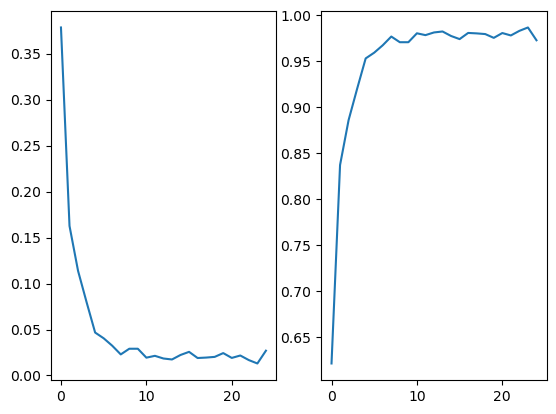

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.plot(history.history['loss'])
# ax1.plot(model_history.history['val_loss'])
# ax1.legend(['Training loss', 'val_loss'])

# ax2.plot(model_history.history['val_dice_coeff'])
ax2.plot(history.history['dice_coeff'])
# ax2.legend(['val_dice_coeff', 'dice_coeff'])

In [32]:
test_image = nib.load(x_train[0]).get_fdata()
test_image = test_image/np.max(test_image)
test_image = test_image.astype(np.float32)
test_image_slice = np.repeat(test_image[:,:,100][...,np.newaxis], 3, axis=-1)
test_image_slice = test_image_slice[np.newaxis,...]

mask = nib.load(y_train[0]).get_fdata()
mask[mask==4] = 3  #Reassign mask values 4 to 3
# mask =  to_categorical(mask[:,:,72], num_classes=4)
# mask = mask.astype(np.float32)
print(mask.shape)

pred = model.predict(test_image_slice)[0]
pred.shape

(240, 240, 155)
1/1 [==============================] - 1s 957ms/step


(240, 240, 4)

In [33]:
# predictions = np.squeeze(pred)
predictions = np.argmax(pred, axis=2)
predictions.shape

(240, 240)

In [34]:
np.unique(predictions)

array([0], dtype=int64)

Text(0.5, 1.0, 'Predicted')

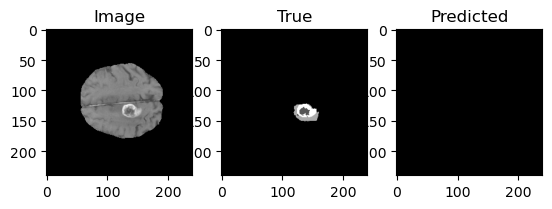

In [35]:
plt.subplot(131)
plt.imshow(test_image[:,:,100], cmap='gray')
plt.title('Image')
plt.subplot(132)
plt.imshow(mask[:,:,100], cmap='gray')
plt.title('True')
plt.subplot(133)
plt.imshow(predictions, cmap='gray')
plt.title("Predicted")

<a id="4"><a>
## Data preparation for pytorch

<a id="5"><a>
# Pytorch 

In [ ]:
# deeplabv3 = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

In [ ]:
resnet50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=True)
resnet50.fc = nn.Identity()
resnet50

In [ ]:
from torchinfo import summary

summary(resnet50, (16,3, 240, 240))

In [ ]:
resnet50.layer3[5].relu

In [ ]:
x = torch.rand(1, 3, 240, 240)
return_nodes = {"layer3.5.relu": "dspp_input", "layer1.2.relu":"decoder_input"}
model2 = create_feature_extractor(resnet50, return_nodes=return_nodes)
intermediate_outputs = model2(x)

In [ ]:
intermediate_outputs["decoder_input"].shape

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class DeepLabv3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabv3Plus, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.resnet50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=True)
        for param in self.resnet50.parameters():
            param.requires_grad = False
        self.resnet50.fc = nn.Identity()
        self.return_nodes = {"layer3.5.relu": "dspp_input", "layer1.2.relu":"decoder_input"}
        self.num_classes = num_classes
        
    def Conv_block(self, Input, num_filters=128, kernel_size=3, dilation_rate=1,padding="same"):
        x = nn.Conv2d(Input.shape[-3], num_filters, kernel_size, padding=padding, dilation=dilation_rate )(Input)
        x = nn.BatchNorm2d(x.shape[-3])(x)
        x = nn.ReLU()(x)
        
        return x
    
    def DilatedSpatialPyramidPooling(self, dspp_input):
        dims = dspp_input.shape
        x = nn.AvgPool2d(kernel_size=(dims[-2],dims[-1]))(dspp_input)
        x = self.Conv_block(x, kernel_size=1)
        out_pool = nn.UpsamplingBilinear2d(size=(dims[-2] // x.shape[-2], dims[-1] // x.shape[-1]))(x)
#         print("Inside dspp, out_pool: ", out_pool.shape)
        out_1 = self.Conv_block(dspp_input, kernel_size=1, dilation_rate=1)
        out_6 = self.Conv_block(dspp_input, kernel_size=3, dilation_rate=6)
        out_12 = self.Conv_block(dspp_input, kernel_size=3, dilation_rate=12)
        out_18 = self.Conv_block(dspp_input, kernel_size=3, dilation_rate=18)
        
        x = torch.cat((out_pool, out_1, out_6, out_12, out_18), 1)
#         print("Inside dspp, after cat: ", x.shape)
        output = self.Conv_block(x, kernel_size=1)
        
        return output
        

    def forward(self, x):
        dims = x.shape
#         print("Input: ", dims)
        model2 = create_feature_extractor(self.resnet50, return_nodes=self.return_nodes)
        intermediate_outputs = model2(x)
        dspp_input = intermediate_outputs["dspp_input"]
        decoder_input = intermediate_outputs["decoder_input"]
        
#         print("dspp in: ", dspp_input.shape)
        dspp_out = self.DilatedSpatialPyramidPooling(dspp_input)
#         print("dspp out", dspp_out.shape)
#         print("dims before upsampling: ", dims)
#         print(dims[-2] //4// dspp_out.shape[-2])
        encoder_out = nn.UpsamplingBilinear2d(scale_factor=(dims[-2] //4// dspp_out.shape[-2], dims[-1] //4// dspp_out.shape[-1]))(dspp_out)
        
        out = self.Conv_block(decoder_input, num_filters=24, kernel_size=1)
#         print("encoder out: ", encoder_out.shape)
#         print("first out: ", out.shape)
        out = torch.cat((encoder_out,out), axis=1)
        out = self.Conv_block(out)
        out = self.Conv_block(out)
        out = nn.UpsamplingBilinear2d(scale_factor=(dims[-2] // out.shape[-2], dims[-1] // out.shape[-1]))(out)
        out = nn.Conv2d(out.shape[1],self.num_classes, kernel_size=1)(out)
        final_out = self.sigmoid(out)
        
        return final_out

In [ ]:
deeplab_pytorch = DeepLabv3Plus(4)

In [ ]:
loss_fn = smp.losses.DiceLoss(mode='multilabel', from_logits=False)
# loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(deeplab_pytorch.parameters() ,lr=0.001)
steps_per_epoch = 10

In [ ]:
# pred_list = []
# run = 0

for epoch in range(2):
    run = 0
    for path_idx in range(len(x_train)):
        s = time.time()
        train_images = []
        train_masks = []

        img_path = x_train[path_idx]
        image_t1ce = nib.load(img_path).get_fdata()
        image_t1ce = image_t1ce/np.max(image_t1ce)
        image_t1ce = image_t1ce.astype(np.float32)
        image_t1ce= image_t1ce[:, :, 30:113]

        mask_path = y_train[path_idx]
        mask = nib.load(mask_path).get_fdata()
        mask[mask==4] = 3  
        mask = mask[:, :, 30:113]

        for j in range(83):
            channel = image_t1ce[:,:,j]
            RGB_img = np.repeat(channel[...,np.newaxis], 3, axis=-1)
            RGB_img = np.moveaxis(RGB_img, -1, 0)
            train_images.append(RGB_img)

            channel = mask[:,:,j]
            channel =  to_categorical(channel, num_classes=4)
            channel = channel.astype(np.float32)
            channel = np.moveaxis(channel, -1, 0)
            train_masks.append(channel)

        train_images = np.array(train_images)
        train_masks = np.array(train_masks)
        
        dice = 0
        for i in range(0,80,steps_per_epoch):
            print("Steps: ", '-'*(i//10+1), end='\r')
            train_x = train_images[i:i+steps_per_epoch]
            train_y = train_masks[i:i+steps_per_epoch]
            
            # start training
            deeplab_pytorch.train()
            x = (torch.from_numpy(train_x))
            y = (torch.from_numpy(train_y))

            # Compute prediction error
            pred = deeplab_pytorch(x)
            loss = loss_fn(y, pred)
            dice += loss.item()
            run += loss.item()
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        e = time.time()
        print("\nExample: {}, Dice Coeff: {},time: {}".format(path_idx, 1-dice/10,e-s) )
        if path_idx % 20 == 0:
            torch.save(deeplab_pytorch.state_dict(), "/kaggle/working/deeplab_pytorch.pth")
    
    # Validation
    deeplab_pytorch.eval()
    with torch.no_grad():
        val_loss = 0
        val_coeff = 0
        for i in range(0,100,10):
            val_img = val_images[i:i+10]
            val_mask = val_masks[i:i+10]
            x, y = torch.from_numpy(val_img), torch.from_numpy(val_mask)
            pred = deeplab_pytorch(x)
            loss = loss_fn(pred, y)
            val_coeff += 1-loss.item()
            val_loss += loss.item()
    
    print("\nEpoch {}: Dice Coeff: {}, running loss: {},time: {}".format(epoch+1, 1-loss.item(), (run/2980),e-s))
    print("\nValidation: Dice Coeff: {}, running loss: {}".format(val_coeff/100, val_loss/100))

In [ ]:
test = torch.from_numpy(train_images[50:60])
predictions = deeplab_pytorch(test)
predictions.shape

In [ ]:
plt.rcParams['figure.figsize']= (25,25)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.5,
                    top=0.3,
                    wspace=0.9,
                    hspace=0.5)

for i in range(5):
    pred = torch.argmax(predictions[i],dim=0)
    true = np.argmax(train_masks[i+50], 0)
    loss = loss_fn(pred, torch.from_numpy(true))
    dice = 1 - loss.item()
    
    plt.subplot(2,5,i+1)
    plt.imshow(true, cmap='gray')
    plt.colorbar()
    plt.title("True")
    
    plt.subplot(2,5,(i+1)+5)
    plt.imshow(pred, cmap='gray')
    plt.colorbar()
    plt.title("Pred: {:.2f}".format(dice))